## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [ ]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [ ]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
#sn.pairplot(diabetes_db)

In [ ]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


mu_val = torch.mean(x_train,dim=0)
std = torch.std(x_train,dim=0)

We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [ ]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  ### your code here
  norm_val=(x-mu)/sigma
  return norm_val


## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [ ]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = torch.mm(x, self.weight.t())
    return y

As we need to account for the bias, we add a column of ones to the `x_data`

In [ ]:
# add a feature for bias
x_train=norm_set(x_train, mu_val, std)
x_test=norm_set(x_test, mu_val, std)
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [ ]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [ ]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  ### your code here
  mse_val = torch.mean((y_pred - y_true) ** 2)
  return mse_val

In [ ]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29711.3223)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [ ]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  # calculate the partial derivative of the loss function with respect to w
  theta = 2/N * torch.mm((y_pred-y).t(), X)
  # calculate the new values the weights
  weight = weight - lr*theta
  model.weight = nn.Parameter(weight, requires_grad=False)

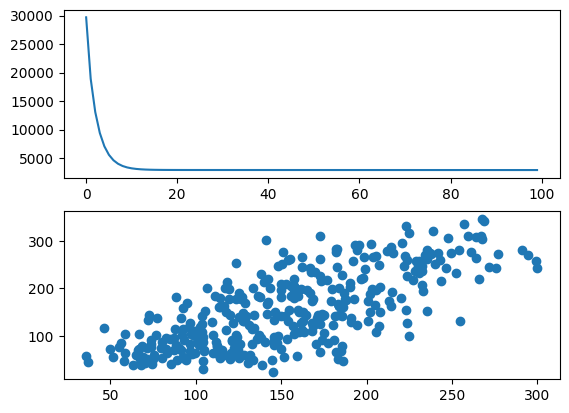

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [ ]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [ ]:
### your code here
X = torch.tensor([[25,1,18,79,130,64.8,61,2,4.1897,68],[50,2,28,103,229,162.2,60,4.5,6.107,124]])
X = norm_set(X, mu_val, std)
val_data = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
prediction = model(val_data)

print(prediction)
print(model.weight)

tensor([[ 66.4351],
        [209.3253]])
Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [ ]:
### your code here
pred=model(x_test)
cost = mean_squared_error(y_test, pred)
print(cost)
print(min(cost_lst))

tensor(2885.6191)
tensor(2890.4065)


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

In [ ]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
# alpha = .01
# alpha = .001
# alpha = .0001
# alpha = .00001
# alpha =1
# alpha =10
for it in range(100):
   prediction = model(x_train)
   cost = mean_squared_error(y_train, prediction)
   cost_lst.append(cost)
   gradient_descent_step(model, x_train, y_train, prediction, alpha)

test_pred = model(x_test)
test_error = mean_squared_error(y_test, test_pred)

print("learning rate:", alpha)
print("train error:", min(cost_lst).item())
print("test error:", test_error.item())

learning rate: 0.1
train error: 2890.406494140625
test error: 2885.619140625


# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

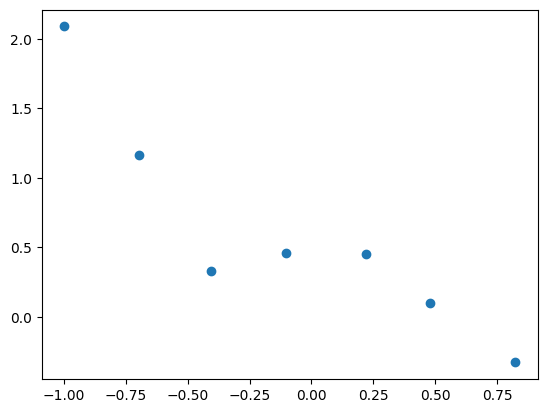

In [ ]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

Adjust variable `x` to include the higher order polynomials

In [ ]:
### your code here
x_1 = x.reshape(-1,1)
x_2 = (x**2).reshape(-1,1)
x_3 = (x**3).reshape(-1,1)
x_4 = (x**4).reshape(-1,1)
x_5 = (x**5).reshape(-1,1)
x3 = torch.cat([x_1,x_2,x_3,x_4,x_5,torch.ones(x.shape[0], 1)], dim=1)
### hint: remember to add x_0 for the bias

**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [ ]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
  ### your code here
  mse_val = 1/2 * torch.mean(torch.pow((y_pred - y_true), 2) + (1/y_pred.shape[0])*lam*torch.sum(torch.pow(theta, 2)))
  return mse_val

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  N = X.shape[0]
  ### your code here
  loss = 1/N*(torch.mm((y_pred - y).t(),X))
  weight[0] = weight[0]-(lr*loss[0])
  weight[1:] = weight[1:]*(1-(lr*lam)/N)  - lr*loss[1:]
  model.weight = nn.Parameter(weight, requires_grad=False)

In [ ]:
model = LinearRegression(x3.shape[1])
prediction=model(x3)
cost = mean_squared_error(prediction,y,0.01,model.weight)
print(cost)

tensor(0.4541)


<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

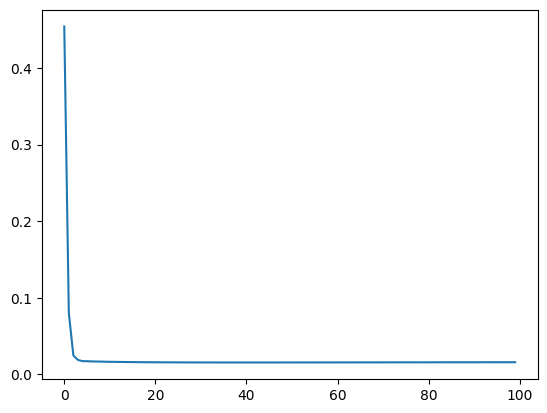

Parameter containing:
tensor([[-0.2919,  0.0907, -0.7664,  0.1417, -0.4623,  0.3817]])
learning rate: 1
Minimum cost: 0.01548904087394476


In [ ]:
cost_lst = list()
model = LinearRegression(x3.shape[1])
# alpha =  0.1 # select an appropriate alpha
# alpha = .01
# alpha = .001
# alpha = .0001
# alpha = .00001
alpha =1
# alpha =10
lam = 0.1 # select an appropriate lambda
for it in range(100):
  prediction = model(x3)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('learning rate:',alpha)
print('Minimum cost: {}'.format(min(cost_lst)))


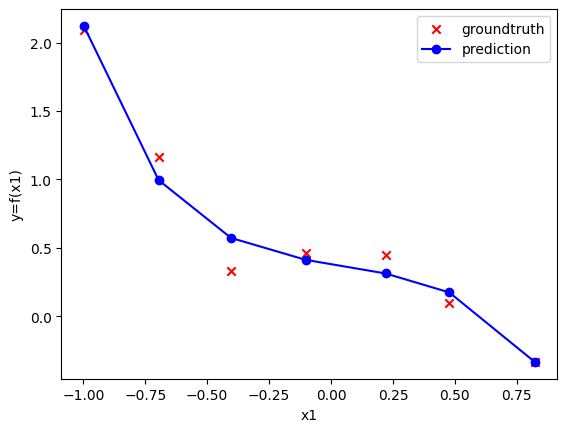

In [ ]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()